In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import polars as pl
import io
import itertools
from brokenaxes import brokenaxes


from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

In [5]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]



In [6]:
basic_filtering = \
    (~pl.col("has_common_transition")) & \
    (pl.col("min_coverage_between_transitions_hap1") >= 3) & \
    (pl.col("min_coverage_between_transitions_hap2") >= 3) & \
    (pl.col("mapq1") >= 60) & \
    (pl.col("mapq2") >= 60) & \
    (pl.col("is_forward1") == pl.col("is_forward2"))

extra_filtering = \
    (pl.col("total_mismatches") <= 100) & \
    (pl.col("total_clipping") <= 10)

# Study hotspots and DSB maps

In [7]:
cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])


In [8]:
trusty_cls_df = (cls_df
    .filter(basic_filtering)
)

very_trusty_cls_df = trusty_cls_df.filter(extra_filtering)

In [9]:
def annotate_with_cM_bam_parquet(
    focal_sample_id, 
    chrom, 
    bam_filename, 
    parquet_filename,
    readlist_filename=None,
    rate_maps=None, 
    cls_df=None,
    AA_hotspots_df=None,
    CL4_hotspots_df=None,
):
    candidates_df = pl.read_parquet(parquet_filename)

    # try:
    rows = []
    for aln in pysam.AlignmentFile(bam_filename).fetch():
        rows.append([aln.query_name, aln.reference_start, aln.reference_end, aln.mapping_quality, aln.query_length])

    rows_df = pl.DataFrame(rows, schema=["read_name", "start_pos_0based", "end_pos_0based", "mapq", "read_length"])

    if rate_maps is not None:
        rate_map = rate_maps[chrom]
        start_poses_cm = rate_map.get_cumulative_mass(rows_df["start_pos_0based"]) * 1e2
        end_poses_cm = rate_map.get_cumulative_mass(rows_df["end_pos_0based"]) * 1e2
    else:    
        start_poses_cm = np.full(len(rows_df), np.nan)
        end_poses_cm = np.full(len(rows_df), np.nan) 

    # Apparently get_cumulative_mass results are in Morgan
    cM = (end_poses_cm - start_poses_cm)

    prob_CO = scipy.stats.poisson.sf(0, cM * 0.01)    

    rows_df = rows_df.with_columns(
        start_pos_cM = start_poses_cm,
        cM = cM,
        prob_CO = prob_CO,
        cM_per_bp_across_read = cM / pl.col("read_length"),
    )
    
    if readlist_filename is not None:
        candidates_df = (candidates_df
            .join(
                pl.read_csv(readlist_filename, new_columns=["read_name"]),
                on="read_name",
            )
        )

    annotated_df = (candidates_df
        .join(rows_df, on="read_name", how="left")
        .with_columns(
            sample_id = pl.lit(focal_sample_id),
            chrom = pl.lit(chrom),            
        )
    )
    
    # Annotate hotspots with respect to the whole read
    if AA_hotspots_df is not None:
        AA_hotspots_df = (AA_hotspots_df
            .filter(pl.col("chrom") == chrom)
            .sort("motif_center_pos")
            .set_sorted("motif_center_pos")
        )
        
        AA_possible_hits = (annotated_df
            .select("read_name", "start_pos_0based", "end_pos_0based")
            .sort("start_pos_0based")
            .set_sorted("start_pos_0based")
            .join_asof(
                AA_hotspots_df.select(
                    AA_motif_center_pos=pl.col("motif_center_pos"), 
                    AA_heat=pl.col("heat"),
                    AA_motif_strand=pl.col("motif_strand"),
                ),
                left_on="start_pos_0based",
                right_on="AA_motif_center_pos",
                strategy="forward",
            )
            .filter((pl.col("AA_motif_center_pos") >= pl.col("start_pos_0based")) & 
                    (pl.col("AA_motif_center_pos") < pl.col("end_pos_0based")))
            .select("read_name", "AA_motif_center_pos", "AA_heat", "AA_motif_strand")
        )
        
        annotated_df = (annotated_df
            .join(
                AA_possible_hits, 
                on="read_name",
                how="left",
            )
        )
        
    if CL4_hotspots_df is not None:
        CL4_hotspots_df = (CL4_hotspots_df
            .filter(pl.col("chrom") == chrom)
            .sort("motif_center_pos")
            .set_sorted("motif_center_pos")
        )
        
        CL4_possible_hits = (annotated_df
            .select("read_name", "start_pos_0based", "end_pos_0based")
            .sort("start_pos_0based")
            .set_sorted("start_pos_0based")
            .join_asof(
                CL4_hotspots_df.select(
                    CL4_motif_center_pos=pl.col("motif_center_pos"), 
                    CL4_heat=pl.col("heat"),
                    CL4_motif_strand=pl.col("motif_strand"),
                ),
                left_on="start_pos_0based",
                right_on="CL4_motif_center_pos",
                strategy="forward",
            )
            .filter((pl.col("CL4_motif_center_pos") >= pl.col("start_pos_0based")) & 
                    (pl.col("CL4_motif_center_pos") < pl.col("end_pos_0based")))
            .select("read_name", "CL4_motif_center_pos", "CL4_heat", "CL4_motif_strand")
        )
        
        annotated_df = (annotated_df
            .join(
                CL4_possible_hits, 
                on="read_name",
                how="left",
            )
        )
    
    if cls_df is not None:
        # Add classification information
        annotated_df = annotated_df.join(
            cls_df.rename({"chrom": "chrom_denovo"}), 
            on=["read_name", "sample_id"], 
            how="left"
        )
        
        # Use that to narrow the cM range
        annotated_df = (annotated_df
            .with_columns(
                active_start_pos = pl.col("start_pos_0based") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
                active_end_pos = pl.col("start_pos_0based") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
            )
            .with_columns(
                active_region_length = pl.col("active_end_pos") - pl.col("active_start_pos"),                
            )
        )
        
        if rate_maps is not None:
            rate_map = rate_maps[chrom]
            active_start_poses_cm = rate_map.get_cumulative_mass(annotated_df["active_start_pos"]) * 1e2
            active_end_poses_cm = rate_map.get_cumulative_mass(annotated_df["active_end_pos"]) * 1e2
        else:    
            active_start_poses_cm = np.full(len(annotated_df), np.nan)
            active_end_poses_cm = np.full(len(annotated_df), np.nan) 

        active_cM = (active_end_poses_cm - active_start_poses_cm)
        
        annotated_df = (annotated_df
            .with_columns(
                active_start_pos_cM = active_start_poses_cm,
                active_end_pos_cM = active_end_poses_cm,
                active_cM = (active_end_poses_cm - active_start_poses_cm),
                cM_per_bp_across_active = (active_end_poses_cm - active_start_poses_cm) / pl.col("active_region_length"),
            )
        )
        
        if AA_hotspots_df is not None:
            annotated_df = (annotated_df
                .with_columns(
                    AA_hotspot_in_active = (
                        (pl.col("active_start_pos") <= pl.col("AA_motif_center_pos")) & \
                        (pl.col("active_end_pos") > pl.col("AA_motif_center_pos"))
                    )
                )
            )
        if CL4_hotspots_df is not None:
            annotated_df = (annotated_df
                .with_columns(
                    CL4_hotspot_in_active = (
                        (pl.col("active_start_pos") <= pl.col("CL4_motif_center_pos")) & \
                        (pl.col("active_end_pos") > pl.col("CL4_motif_center_pos"))
                    )
                )
            )
        
            
    
    return annotated_df

def annotate_with_cM_grch37(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.aligned_to_grch37.bam"
    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename, 
        rate_maps = annotate.rate_maps,
        cls_df = cls_df,
    )

def annotate_with_cM_grch38(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.aligned_to_grch38.bam"
    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename, 
        rate_maps = None,
        cls_df = cls_df,
        AA_hotspots_df = AA_hotspots_df,
        CL4_hotspots_df = CL4_hotspots_df,
    )

def annotate_with_cM_T2T(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.aligned_to_T2T.bam"
    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.candidate_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename,
        rate_maps = None,
        cls_df = cls_df,
    )

def annotate_with_cM_grch37_random(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.random_reads.aligned_to_grch37.bam"
    
    candidates_readlist_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.random_reads.read_names_grch37.txt"    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.all_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename, 
        readlist_filename = candidates_readlist_filename,
        rate_maps = annotate.rate_maps,
        cls_df = None,
    )

def annotate_with_cM_grch37_1e5_random(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.1e5_random_reads.aligned_to_grch37.bam"
    
    candidates_readlist_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.1e5_random_reads.read_names_grch37.txt"    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.all_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename, 
        readlist_filename = candidates_readlist_filename,
        rate_maps = annotate.rate_maps,
        cls_df = None,
    )

def annotate_with_cM_grch38_random(focal_sample_id, chrom):
    candidates_bam_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.random_reads.aligned_to_grch38.bam"
    
    candidates_readlist_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.random_reads.read_names_grch38.txt"    

    candidates_parquet_filename = \
        Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.all_reads.parquet"
    
    return annotate_with_cM_bam_parquet(
        focal_sample_id, chrom, candidates_bam_filename, candidates_parquet_filename, 
        readlist_filename = candidates_readlist_filename,
        rate_maps = None,
        cls_df = None,
        AA_hotspots_df = AA_hotspots_df,
        CL4_hotspots_df = CL4_hotspots_df,
    )

In [10]:
all_annotated_random_df = \
    pl.concat(
        joblib.Parallel(n_jobs=-1, verbose=10)(
            joblib.delayed(annotate_with_cM_grch37_random)(focal_sample_id, chrom) 
                for focal_sample_id in sample_ids for chrom in aut_chrom_names
        )
    )

all_annotated_random_df = all_annotated_random_df.drop_nulls()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:   

In [11]:
all_annotated_random_more_grch37_df = \
    pl.concat(
        joblib.Parallel(n_jobs=-1, verbose=10)(
            joblib.delayed(annotate_with_cM_grch37_1e5_random)(focal_sample_id, chrom) 
                for focal_sample_id in sample_ids for chrom in aut_chrom_names
        )
    )

all_annotated_random_more_grch37_df = all_annotated_random_more_grch37_df.drop_nulls()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:  3

In [12]:
all_annotated_candidates_T2T_df = \
    pl.concat(
        joblib.Parallel(n_jobs=-1, verbose=10)(
            joblib.delayed(annotate_with_cM_T2T)(focal_sample_id, chrom) 
               for focal_sample_id in sample_ids for chrom in aut_chrom_names
        )
    )

filtered_annotated_candidates_T2T_df_expanded = all_annotated_candidates_T2T_df.filter(basic_filtering & extra_filtering)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10741233825683594s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14485597610473633s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 183 out of 198 | elapsed:    1.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 198 out of 198 | elapsed:    1.8s finished


# Functions to get call set for a subset of samples

In [13]:
def generate_call_set(
    focal_sample_ids, 
    take_every=1, 
    bootstrap=False, 
    cutoff=None, 
    min_snps=0,
    read_list_filename_pattern = None,
    include_candidates=False,
):
    certainty = "0.95"
    
    # Get all the other reads
    all_sampled_reads = []

    for focal_sample_id in focal_sample_ids:
        for t2t_chrom in aut_chrom_names:
            denovo_chrom = t2t_chrom + "_RagTag"

            patterns_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_{certainty}.candidate_reads.patterns.parquet"
            
            pat_df = pl.scan_parquet(patterns_filename)
            
            if read_list_filename_pattern is not None:
                read_list_filename = read_list_filename_pattern.format(sample_id=focal_sample_id, chrom=denovo_chrom)
                read_list_df = pl.scan_csv(read_list_filename, new_columns=["read_name"])
                pat_df = pat_df.join(read_list_df, on="read_name")
                
            pat_df = pat_df.gather_every(take_every)

            all_sampled_reads.append(pat_df)

    all_sampled_reads = pl.concat(all_sampled_reads).collect(streaming=True)
    
    # Create the joint dataframe
    if include_candidates:
        both_df = (
            pl.concat([
                (very_trusty_cls_df
                    .filter(pl.col("class") != "CNCO")
                    .filter(pl.col("sample_id").is_in(focal_sample_ids))
                    .select(["read_length", "snp_positions_on_read", "idx_transitions", "sample_id", "read_name"])
                    .with_columns(weight = 1)
                ), 
                (all_sampled_reads
                    .select(["read_length", "snp_positions_on_read", "idx_transitions", "sample_id", "read_name"])
                    .with_columns(weight = take_every)
                )
            ])
        )
    else:
        both_df = (
            (all_sampled_reads
                .select(["read_length", "snp_positions_on_read", "idx_transitions", "sample_id", "read_name"])
                .with_columns(weight = take_every)
            )
        )
    
    # Make sure we have minimal number of SNPs
    both_df = both_df.filter(pl.col("snp_positions_on_read").list.len() >= min_snps)
    
    # Cutoff if needed
    if cutoff:
        both_df = both_df.filter(
            pl.when(pl.col("idx_transitions").list.len() != 2).then(pl.lit(True)).otherwise(
                (pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1) - \
                 pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0))) < cutoff
            )
        )
    
    # Bootstrap if needed
    if bootstrap:
        both_df = both_df.sample(n = len(both_df), with_replacement = True)
    
    # Add useful fields
    aug_both_df = (both_df
        .with_columns(
            prob_inside = 1 - (pl.col("snp_positions_on_read").list.get(0) + pl.col("read_length") - pl.col("snp_positions_on_read").list.get(-1)) / pl.col("read_length"),
            n_transitions = pl.col("idx_transitions").list.len(),
        )
        .with_columns(
            rounded_prob_inside = pl.col("prob_inside") // 0.1 * 0.1,
        )
    )
    
    return aug_both_df


# Get all reads, except complex (about 27GB)

In [14]:
%%time
all_df = generate_call_set(
    sample_ids, 
    take_every=1,
    read_list_filename_pattern = str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / "{sample_id}" / "reads" / "{chrom}.certainty_0.95.1e5_random_reads.read_names_grch37.txt"),
)

CPU times: user 49.6 s, sys: 16.7 s, total: 1min 6s
Wall time: 1min 52s


In [15]:
annotated_all_df = all_df.join(all_annotated_random_more_grch37_df, on="read_name")

In [16]:
recombination_boosting_factor = 1

def runme(chrom, CO, GC_tract_mean):
    rate_map = annotate.rate_maps[chrom]
    annotated_chrom_df = annotated_all_df.filter(pl.col("chrom") == chrom)

    idx_transitions_list, event_indices, n_noevents = inference.simulate_read_patterns_genetic_map(
        read_genetic_length_in_cM_list = np.array(annotated_chrom_df["cM"]) * recombination_boosting_factor,
        snp_positions_on_read_list = np.array(annotated_chrom_df["snp_positions_on_read"]),
        read_starts_list = np.array(annotated_chrom_df["start_pos_0based"]),
        read_ends_list = np.array(annotated_chrom_df["end_pos_0based"]),
        rate_map = rate_map,
        random_seed = 6666,
        CO = CO,
        GC_tract_mean = GC_tract_mean,
    )

    detected_event_indices = np.array([E for L, E in zip(idx_transitions_list, event_indices) if len(L)])
    
    if len(detected_event_indices) == 0:
        return annotated_chrom_df.filter(pl.lit(False))

    subset_detected_df = annotated_chrom_df[detected_event_indices]
    return subset_detected_df
    
all_subset_detected_CO_df = pl.concat(joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(runme)(chrom, True, None) for chrom in aut_chrom_names
))

all_subset_detected_GC_df = pl.concat(joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(runme)(chrom, False, 30) for chrom in aut_chrom_names
))



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 out of  22 | elapsed:  6.3min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  13 out of  22 | elapsed:  8.1min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  16 out of  22 | elapsed:  9.8min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed: 11.6min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed: 13.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  

In [17]:
all_subset_detected_CO_df

read_length,snp_positions_on_read,idx_transitions,sample_id,read_name,weight,prob_inside,n_transitions,rounded_prob_inside,frac_fits1_more_snps_high_conf,mapq1,mapq2,is_forward1,is_forward2,total_mismatches,num_common_insertions,num_common_deletions,total_clipping,start_pos_0based,end_pos_0based,mapq,read_length_right,start_pos_cM,cM,prob_CO,cM_per_bp_across_read,sample_id_right,chrom
i64,list[i64],list[i64],str,str,i32,f64,u32,f64,f64,i32,i32,bool,bool,i64,u32,u32,i64,i64,i64,i64,i64,f64,f64,f64,f64,str,str
19104,"[531, 1835, … 7331]",[],"""PD50477f""","""m64178e_220829…",1,0.355946,0,0.3,1.0,60,60,true,true,0,2,5,0,208402106,208421213,60,19104,148.722368,0.068007,0.00068,0.000004,"""PD50477f""","""chr1"""
12865,"[6031, 6978, … 12259]",[],"""PD50477f""","""m64094e_220917…",1,0.484104,0,0.4,0.0,60,60,false,false,0,3,2,0,38908273,38921134,60,12865,48.980677,0.081521,0.000815,0.000006,"""PD50477f""","""chr1"""
15009,"[1946, 3413, … 14424]",[],"""PD50477f""","""m64094e_220917…",1,0.831368,0,0.8,0.0,60,60,true,true,0,0,4,0,191858589,191873602,60,15009,138.107406,0.060735,0.000607,0.000004,"""PD50477f""","""chr1"""
11600,"[576, 680, … 10468]",[],"""PD50477f""","""m64094e_220917…",1,0.852759,0,0.8,1.0,60,60,true,true,2,1,2,10,175083326,175094995,60,11600,127.142379,0.097109,0.000971,0.000008,"""PD50477f""","""chr1"""
12887,"[1190, 1313, … 9390]",[],"""PD50477f""","""m64230e_220906…",1,0.6363,0,0.6,0.0,60,60,true,true,1,2,32,0,216691819,216704745,60,12887,155.017244,0.027467,0.000275,0.000002,"""PD50477f""","""chr1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
18877,"[694, 939, … 18008]",[],"""PD50489e""","""m64094e_220715…",1,0.917201,0,0.9,1.0,60,60,true,true,0,10,8,0,22519607,22538072,60,18877,8.467529,0.019759,0.000198,0.000001,"""PD50489e""","""chr22"""
5753,"[815, 861, … 5024]",[],"""PD50489e""","""m64174e_220620…",1,0.731618,0,0.7,1.0,60,60,false,false,1,3,0,0,25662662,25668401,60,5753,14.058819,0.359244,0.003586,0.000062,"""PD50489e""","""chr22"""
6391,"[509, 2398, … 5869]",[],"""PD50489e""","""m64094e_220715…",1,0.838679,0,0.8,1.0,60,60,true,true,0,5,4,0,49550581,49556617,60,6391,53.935865,0.451091,0.004501,0.000071,"""PD50489e""","""chr22"""


In [18]:
all_subset_detected_GC_df

read_length,snp_positions_on_read,idx_transitions,sample_id,read_name,weight,prob_inside,n_transitions,rounded_prob_inside,frac_fits1_more_snps_high_conf,mapq1,mapq2,is_forward1,is_forward2,total_mismatches,num_common_insertions,num_common_deletions,total_clipping,start_pos_0based,end_pos_0based,mapq,read_length_right,start_pos_cM,cM,prob_CO,cM_per_bp_across_read,sample_id_right,chrom
i64,list[i64],list[i64],str,str,i32,f64,u32,f64,f64,i32,i32,bool,bool,i64,u32,u32,i64,i64,i64,i64,i64,f64,f64,f64,f64,str,str
14374,"[6225, 7336, … 13097]",[],"""PD50521b""","""m64229e_220912…",1,0.478085,0,0.4,0.0,60,60,true,true,0,0,1,0,209826719,209841094,60,14374,150.446579,0.166255,0.001661,0.000012,"""PD50521b""","""chr1"""
18580,"[2349, 2822, … 16132]",[],"""PD46180c""","""m64016e_220904…",1,0.741819,0,0.7,0.0,60,60,true,true,4,11,108,0,25495816,25514486,60,18580,40.094155,0.031054,0.00031,0.000002,"""PD46180c""","""chr1"""
12877,"[1006, 1446, … 11508]",[],"""PD50477f""","""m64178e_220829…",1,0.815563,0,0.8,0.0,60,60,false,false,0,3,11,0,238315945,238328836,60,12877,172.823985,0.292562,0.002921,0.000023,"""PD50477f""","""chr2"""
14454,"[2690, 3274, … 13524]",[],"""PD50508b""","""m64178e_220826…",1,0.74955,0,0.7,0.0,60,60,false,false,0,1,3,6,46479948,46494413,60,14454,52.643856,0.1671,0.00167,0.000012,"""PD50508b""","""chr2"""
25896,"[985, 1090, … 22077]",[],"""PD50519d""","""m64221e_220814…",1,0.814489,0,0.8,1.0,60,60,false,false,0,8,27,0,5429488,5455435,60,25896,21.358273,0.031859,0.000319,0.000001,"""PD50519d""","""chr3"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
19845,"[4009, 6697]",[],"""PD50508b""","""m64178e_220826…",1,0.13545,0,0.1,1.0,60,60,false,false,0,7,11,0,39281444,39301289,60,19845,26.492387,0.131875,0.001318,0.000007,"""PD50508b""","""chr21"""
19164,"[5589, 5998, … 17406]",[],"""PD50508f""","""m64230e_220901…",1,0.616625,0,0.6,0.0,60,60,true,true,2,21,29,0,48892971,48912155,60,19164,50.666799,0.352462,0.003518,0.000018,"""PD50508f""","""chr22"""
13735,"[697, 770, … 12087]",[],"""PD50508b""","""m64016e_220905…",1,0.829268,0,0.8,0.0,60,60,true,true,0,0,1,0,44523452,44537194,60,13735,36.37627,0.388249,0.003875,0.000028,"""PD50508b""","""chr22"""


# Plot distance to telomeres

In [19]:
all_poses_df = (filtered_annotated_candidates_T2T_df_expanded
    .join(
        very_trusty_cls_df.select("read_name"), 
        on="read_name",
    )
    .select(
        "read_name",
        "sample_id",
        "chrom",
        "class",
        "start_pos_0based",
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)).alias("snp_before"),
        pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0) + 1).alias("snp_after"),
    )
    .with_columns(
        (pl.col("start_pos_0based") + (pl.col("snp_after") - pl.col("snp_before"))//2).alias("pos_average"),
    )
    .join(
        pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "chrom_length"]),
        on="chrom",
    )
)

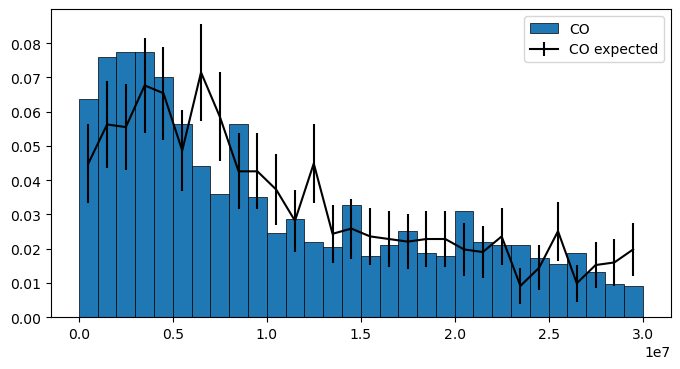

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))

bins = np.arange(0, 3e7+1e6, 1e6)

# Plot observed CO 
counts = np.histogram(
    all_poses_df.filter(pl.col("class") == "CO").select(
        pl.min_horizontal(
            pl.col("pos_average"),
            pl.col("chrom_length") - pl.col("pos_average"),
        ).alias("dist")
    )["dist"],
    bins = bins,
)[0]

counts = counts / counts.sum()

xs = (bins[1:]+bins[:-1])/2
ax.bar(
    x = xs,
    height = counts,
    width = (bins[1]-bins[0]), #*0.8,
#        s = 24,
    label = "CO",
    color = "C0",
    edgecolor = "black",
    linewidth = 0.5,
);

# Now plot expectation of detecting COs according to genetic map
df = (all_subset_detected_CO_df
    .join(
        pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "chrom_length"]),
        on="chrom",
    ) 
    .with_columns(
        start_dist = (pl.col("start_pos_0based") + pl.col("end_pos_0based")) // 2,
    )
    .with_columns(
        end_dist = pl.col("chrom_length") - pl.col("start_dist"),
    )
)

exp_counts = np.histogram(
    np.minimum(df["start_dist"], df["end_dist"]),
    bins = bins,
)[0]

diric = scipy.stats.dirichlet(exp_counts + 1)

ax.errorbar(
    x = xs,
    y = diric.mean(),
    yerr = (diric.var() ** 0.5)*2,
    color="black",
    label = "CO expected"
);

#ax.set_ylim(0, 0.2)
ax.legend()

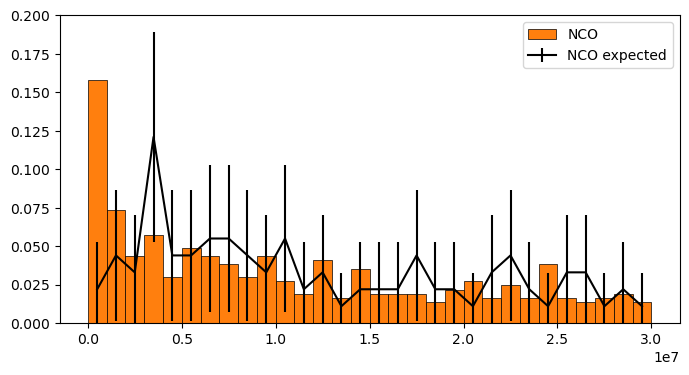

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))

bins = np.arange(0, 3e7+1e6, 1e6)

# Plot observed CO 
counts = np.histogram(
    all_poses_df.filter(pl.col("class") == "GC").select(
        pl.min_horizontal(
            pl.col("pos_average"),
            pl.col("chrom_length") - pl.col("pos_average"),
        ).alias("dist")
    )["dist"],
    bins = bins,
)[0]

counts = counts / counts.sum()

xs = (bins[1:]+bins[:-1])/2
ax.bar(
    x = xs,
    height = counts,
    width = (bins[1]-bins[0]), #*0.8,
#        s = 24,
    label = "NCO",
    color = "C1",
    edgecolor = "black",
    linewidth = 0.5,
);

# Now plot expectation of detecting GCs according to genetic map
df = (all_subset_detected_GC_df
    .join(
        pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "chrom_length"]),
        on="chrom",
    ) 
    .with_columns(
        start_dist = (pl.col("start_pos_0based") + pl.col("end_pos_0based")) // 2,
    )
    .with_columns(
        end_dist = pl.col("chrom_length") - pl.col("start_dist"),
    )
)

exp_counts = np.histogram(
    np.minimum(df["start_dist"], df["end_dist"]),
    bins = bins,
)[0]

diric = scipy.stats.dirichlet(exp_counts + 1)

ax.errorbar(
    x = xs,
    y = diric.mean(),
    yerr = (diric.var() ** 0.5)*2,
    color="black",
    label = "NCO expected"
);


ax.set_ylim(0, 0.2)
ax.legend()

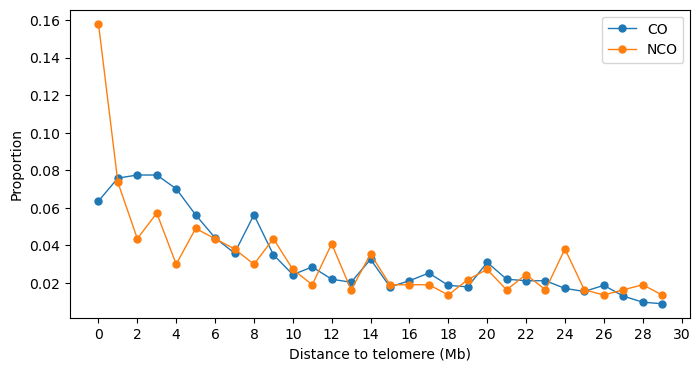

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))

bins = np.arange(0, 3e7+1e6, 1e6)
xs = bins[:-1] #(bins[1:]+bins[:-1])/2

# Plot observed CO 
counts = np.histogram(
    all_poses_df.filter(pl.col("class") == "CO").select(
        pl.min_horizontal(
            pl.col("pos_average"),
            pl.col("chrom_length") - pl.col("pos_average"),
        ).alias("dist")
    ),
    bins = bins,
)[0]

counts = counts / counts.sum()

ax.plot(
    xs,
    counts,
    '.-',
    ms = 10,
    label = "CO",
    color = "C0",
    lw=1,
);

# Plot observed NCO 
counts = np.histogram(
    all_poses_df.filter(pl.col("class") == "GC").select(
        pl.min_horizontal(
            pl.col("pos_average"),
            pl.col("chrom_length") - pl.col("pos_average"),
        ).alias("dist")
    ),
    bins = bins,
)[0]
counts = counts / counts.sum()

ax.plot(
    xs,
    counts,
    '.-',
    ms = 10,
    label = "NCO",
    color = "C1",
    lw=1,
);

ax.legend()
#ax.set_ylim(0, 0.2);

ax.set_xticks(
    bins[::2],
    labels = [f"{int(x/1e6)}" for x in bins[::2]],
#    rotation=45,    
)

ax.set_xlabel("Distance to telomere (Mb)");
ax.set_ylabel("Proportion");

In [23]:
all_poses_df.filter(pl.col("class") == "CO").select(
        pl.min_horizontal(
            pl.col("pos_average"),
            pl.col("chrom_length") - pl.col("pos_average"),
        ).alias("dist")
    ).max()

dist
i64
118742862
